In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'

In [2]:
!kaggle datasets download -d adrianboguszewski/landcoverai

100% 1.43G/1.43G [00:46<00:00, 24.3MB/s]
100% 1.43G/1.43G [00:46<00:00, 33.3MB/s]


In [3]:
!unzip /content/landcoverai.zip

Archive:  /content/landcoverai.zip
  inflating: images/M-33-20-D-c-4-2.tif  
  inflating: images/M-33-20-D-d-3-3.tif  
  inflating: images/M-33-32-B-b-4-4.tif  
  inflating: images/M-33-48-A-c-4-4.tif  
  inflating: images/M-33-7-A-d-2-3.tif  
  inflating: images/M-33-7-A-d-3-2.tif  
  inflating: images/M-34-32-B-a-4-3.tif  
  inflating: images/M-34-32-B-b-1-3.tif  
  inflating: images/M-34-5-D-d-4-2.tif  
  inflating: images/M-34-51-C-b-2-1.tif  
  inflating: images/M-34-51-C-d-4-1.tif  
  inflating: images/M-34-55-B-b-4-1.tif  
  inflating: images/M-34-56-A-b-1-4.tif  
  inflating: images/M-34-6-A-d-2-2.tif  
  inflating: images/M-34-65-D-a-4-4.tif  
  inflating: images/M-34-65-D-c-4-2.tif  
  inflating: images/M-34-65-D-d-4-1.tif  
  inflating: images/M-34-68-B-a-1-3.tif  
  inflating: images/M-34-77-B-c-2-3.tif  
  inflating: images/N-33-104-A-c-1-1.tif  
  inflating: images/N-33-119-C-c-3-3.tif  
  inflating: images/N-33-130-A-d-3-3.tif  
  inflating: images/N-33-130-A-d-4-4.tif  

In [4]:
import os
import numpy as np
import glob 
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

In [5]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 8.0 MB/s 


In [7]:
from patchify import patchify

In [8]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


Labels are:  [0 1 2 3 4]  and the counts are:  [23401744  1167023 14924792 40573354  2735233]


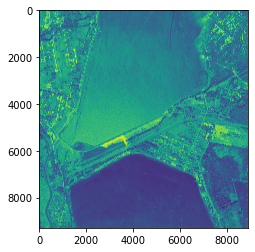

In [9]:
import os
import cv2
import numpy as np
import glob

import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random

#Quick understanding of the dataset
temp_img = cv2.imread("/content/images/M-34-51-C-d-4-1.tif") #3 channels / spectral bands
plt.imshow(temp_img[:,:,2]) #View each channel...
temp_mask = cv2.imread("/content/masks/M-34-51-C-d-4-1.tif") #3 channels but all same. 
labels, count = np.unique(temp_mask[:,:,0], return_counts=True) #Check for each channel. All chanels are identical
print("Labels are: ", labels, " and the counts are: ", count)
#########

In [10]:

#Now, crop each large image into patches of 256x256. Save them into a directory 
#so we can use data augmentation and read directly from the drive. 
root_directory = '/content/' 
image_dataset = []
patch_size = 256
img_dir=root_directory+"images/"
for path, subdirs, files in os.walk(img_dir):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    #print(dirname)
    images = os.listdir(path)  #List of all image names in this subdirectory
    # print(images)
    for i, image_name in enumerate(images):  
        if image_name.endswith(".tif"):
            #print(image_name)
            image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
            SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            image = Image.fromarray(image)
            image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            image = np.array(image)             
   
            #Extract patches from each image
            print("Now patchifying image:", path+"/"+image_name)
            patches_img = patchify(image, (256, 256, 3), step=256)  #Step=256 for 256 patches means no overlap
    
            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    
                    single_patch_img = patches_img[i,j,:,:]
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. #We will preprocess using one of the backbones
                    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                    
                    cv2.imwrite(root_directory+"256_patches/images/"+image_name+"patch_"+str(i)+str(j)+".tif", single_patch_img)
#                     image_dataset.append(single_patch_img)
    

Now patchifying image: /content/images//N-34-106-A-c-1-3.tif
Now patchifying image: /content/images//N-34-140-A-d-4-2.tif
Now patchifying image: /content/images//M-34-56-A-b-1-4.tif
Now patchifying image: /content/images//N-34-77-A-b-1-4.tif
Now patchifying image: /content/images//M-33-7-A-d-2-3.tif
Now patchifying image: /content/images//N-33-130-A-d-4-4.tif
Now patchifying image: /content/images//M-33-20-D-c-4-2.tif
Now patchifying image: /content/images//M-34-65-D-a-4-4.tif
Now patchifying image: /content/images//N-33-139-D-c-1-3.tif
Now patchifying image: /content/images//M-34-65-D-d-4-1.tif
Now patchifying image: /content/images//N-34-66-C-c-4-3.tif
Now patchifying image: /content/images//M-33-32-B-b-4-4.tif
Now patchifying image: /content/images//N-34-140-A-d-3-4.tif
Now patchifying image: /content/images//M-34-68-B-a-1-3.tif
Now patchifying image: /content/images//M-33-7-A-d-3-2.tif
Now patchifying image: /content/images//M-33-48-A-c-4-4.tif
Now patchifying image: /content/image

In [11]:
root_directory = '/content/' 

mask_dir=root_directory+"masks/"
mask_dataset = []
image_dataset = []
patch_size = 256
for path, subdirs, files in os.walk(mask_dir):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]

    masks = os.listdir(path)  #List of all image names in this subdirectory
    for i, mask_name in enumerate(masks):  
        if mask_name.endswith(".tif"):           
            mask = cv2.imread(path+"/"+mask_name, 0)  #Read each image as Grey (or color but remember to map each color to an integer)
            SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
            SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
            mask = Image.fromarray(mask)
            mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
            #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
            mask = np.array(mask)             
   
            #Extract patches from each image
            print("Now patchifying mask:", path+"/"+mask_name)
            patches_mask = patchify(mask, (256, 256), step=256)  #Step=256 for 256 patches means no overlap
    
            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):
                    
                    single_patch_mask = patches_mask[i,j,:,:]
                    #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                    #single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                    cv2.imwrite(root_directory+"256_patches/masks/"+ mask_name+"patch_"+str(i)+str(j)+".tif", single_patch_mask)
                    mask_dataset.append(single_patch_mask)


Now patchifying mask: /content/masks//N-34-106-A-c-1-3.tif
Now patchifying mask: /content/masks//N-34-140-A-d-4-2.tif
Now patchifying mask: /content/masks//M-34-56-A-b-1-4.tif
Now patchifying mask: /content/masks//N-34-77-A-b-1-4.tif
Now patchifying mask: /content/masks//M-33-7-A-d-2-3.tif
Now patchifying mask: /content/masks//N-33-130-A-d-4-4.tif
Now patchifying mask: /content/masks//M-33-20-D-c-4-2.tif
Now patchifying mask: /content/masks//M-34-65-D-a-4-4.tif
Now patchifying mask: /content/masks//N-33-139-D-c-1-3.tif
Now patchifying mask: /content/masks//M-34-65-D-d-4-1.tif
Now patchifying mask: /content/masks//N-34-66-C-c-4-3.tif
Now patchifying mask: /content/masks//M-33-32-B-b-4-4.tif
Now patchifying mask: /content/masks//N-34-140-A-d-3-4.tif
Now patchifying mask: /content/masks//M-34-68-B-a-1-3.tif
Now patchifying mask: /content/masks//M-33-7-A-d-3-2.tif
Now patchifying mask: /content/masks//M-33-48-A-c-4-4.tif
Now patchifying mask: /content/masks//M-34-32-B-b-1-3.tif
Now patchif

In [14]:
# mask_dataset

In [15]:
# mask_dataset[0:3]

In [ ]:
# print("Labels in the mask are : ", np.unique(mask_dataset))

In [12]:

train_img_dir = "/content/256_patches/images/"
train_mask_dir = "/content/256_patches/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))
print(num_images)

41646


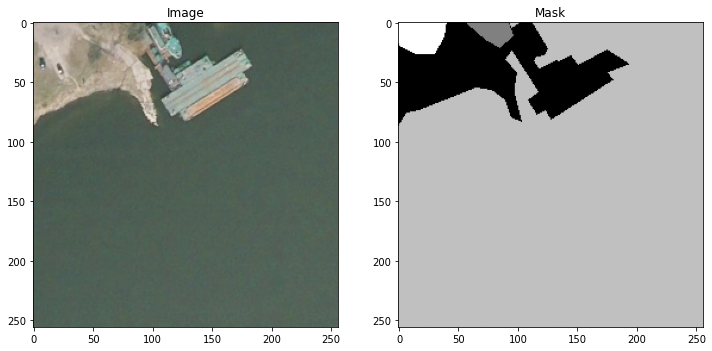

In [41]:
img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()


In [ ]:

#Now, let us copy images and masks with real information to a new folder.
# real information = if mask has decent amount of labels other than 0. 

useless=0  #Useless image counter
for img in range(len(img_list)):   #Using t1_list as all lists are of same size
    img_name=img_list[img]
    mask_name = msk_list[img]
    print("Now preparing image and masks number: ", img)
      
    temp_image=cv2.imread(train_img_dir+img_list[img], 1)
   
    temp_mask=cv2.imread(train_mask_dir+msk_list[img], 0)
    #temp_mask=temp_mask.astype(np.uint8)
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.05:  #At least 5% useful area with labels that are not 0
        print("Save Me")
        cv2.imwrite('/content/256_patches/images_with_useful_info/images/'+img_name, temp_image)
        cv2.imwrite('/content/256_patches/images_with_useful_info/masks/'+mask_name, temp_mask)
        
    else:
        print("I am useless")   
        useless +=1

print("Total useful images are: ", len(img_list)-useless)  #20,075
print("Total useless images are: ", useless) #21,571

In [15]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:

"""
Code for splitting folder into train, test, and val.
Once the new folders are created rename them and arrange in the format below to be used
for semantic segmentation using data generators. 

pip install split-folders
"""
import splitfolders  # or import split_folders

input_folder = '/content/256_patches/images_with_useful_info/'
output_folder = '/content/data_for_training_and_testing/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values
####

Copying files: 43848 files [00:48, 901.66 files/s] 


## Change File Strucure HERE!

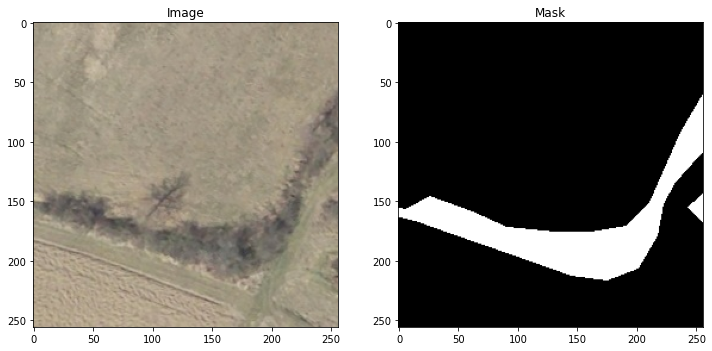

In [18]:

import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random

# tf.compat.v1.disable_eager_execution() #in case the model gets very slow, may be due to a bug in TF2.0. Uncomment this. 
#https://github.com/tensorflow/tensorflow/issues/33024

#Also check this in case you notice training to be getting increasingly slow each epoch.
# https://stackoverflow.com/questions/53683164/keras-occupies-an-indefinitely-increasing-amount-of-memory-for-each-epoch

################################################################
#Get an understanding by looking at a few random images and masks 

train_img_dir = "/content/data_for_keras_aug/train_images/train/"
train_mask_dir = "/content/data_for_keras_aug/train_masks/train/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))


img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()


In [19]:

seed=24
batch_size= 16
n_classes=5

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from tensorflow.keras.utils import to_categorical

#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

#Define a function to perform additional preprocessing after datagen.
#For example, scale images, convert masks to categorical, etc. 
def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    #Convert mask to one-hot
    mask = to_categorical(mask, num_class)
      
    return (img,mask)

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [21]:
train_img_path = "/content/data_for_keras_aug/train_images/"
train_mask_path = "/content/data_for_keras_aug/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=5)

val_img_path = "/content/data_for_keras_aug/val_images/"
val_mask_path = "/content/data_for_keras_aug/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=5)

In [22]:
x, y = train_img_gen.__next__()

Found 16443 images belonging to 2 classes.
Found 16443 images belonging to 2 classes.


In [23]:
x_val, y_val = val_img_gen.__next__()

Found 5481 images belonging to 2 classes.
Found 5481 images belonging to 2 classes.


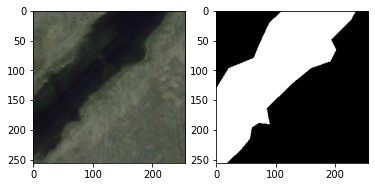

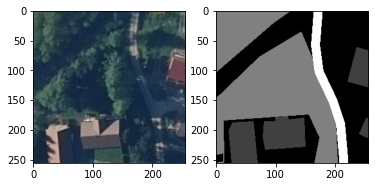

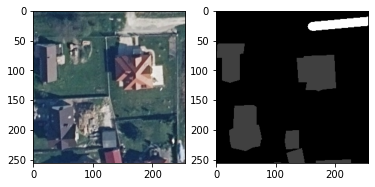

In [24]:
for i in range(0,3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [25]:

num_train_imgs = len(os.listdir('/content/data_for_keras_aug/train_images/train/'))
num_val_images = len(os.listdir('/content/data_for_keras_aug/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size
print(num_train_imgs,num_val_images,steps_per_epoch,val_steps_per_epoch)

IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]



16443 5481 1027 342


In [26]:

sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [27]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet',input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),classes=n_classes, activation='softmax')
model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

#Other losses to try: categorical_focal_dice_loss, cce_jaccard_loss, cce_dice_loss, categorical_focal_loss

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
print(model.summary())
print(model.input_shape)

85532672/85521592 [==============================] - 6s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)            

In [28]:
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=25,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)

Epoch 1/25
1027/1027 [==============================] - 407s 375ms/step - loss: 0.5528 - iou_score: 0.4865 - val_loss: 0.9858 - val_iou_score: 0.1841
Epoch 2/25
1027/1027 [==============================] - 358s 349ms/step - loss: 0.4667 - iou_score: 0.5681 - val_loss: 0.4741 - val_iou_score: 0.5628
Epoch 3/25
1027/1027 [==============================] - 361s 352ms/step - loss: 0.4259 - iou_score: 0.6053 - val_loss: 0.4967 - val_iou_score: 0.5393
Epoch 4/25
1027/1027 [==============================] - 353s 344ms/step - loss: 0.4053 - iou_score: 0.6241 - val_loss: 0.5032 - val_iou_score: 0.5392
Epoch 5/25
1027/1027 [==============================] - 353s 344ms/step - loss: 0.3862 - iou_score: 0.6417 - val_loss: 0.4090 - val_iou_score: 0.6219
Epoch 6/25
1027/1027 [==============================] - 360s 351ms/step - loss: 0.3738 - iou_score: 0.6529 - val_loss: 0.3692 - val_iou_score: 0.6562
Epoch 7/25
1027/1027 [==============================] - 360s 351ms/step - loss: 0.3628 - iou_score: 

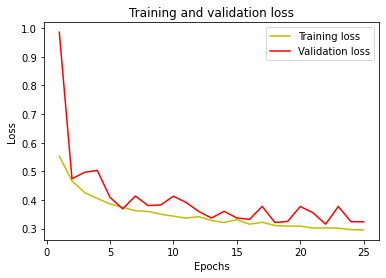

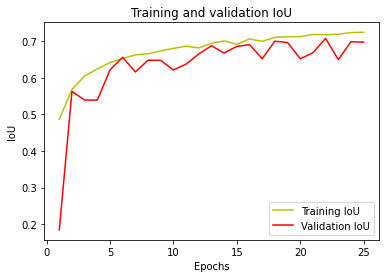

In [29]:

##################################################################
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [30]:
model.save('landcover_25_epochs_RESNET_backbone_batch16.hdf5')

In [31]:

from keras.models import load_model

model = load_model("landcover_25_epochs_RESNET_backbone_batch16.hdf5", compile=False)

#batch_size=32 #Check IoU for a batch of images

#Test generator using validation data.

test_image_batch, test_mask_batch = val_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)


Mean IoU = 0.7248951


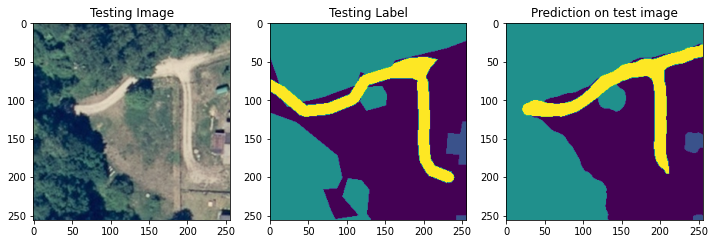

In [35]:

n_classes = 5
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#######################################################
#View a few images, masks and corresponding predictions. 
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()